In [3]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u

## Open a test data

In [4]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [26]:
cosmo = extragalactic_cat.cosmology

In [11]:
extragalactic_cat.list_all_quantities()

['mag_u_lsst',
 'size_true',
 'mag_true_Y_lsst_no_host_extinction',
 'mag_true_Y_lsst',
 'ra_true',
 'sersic_bulge',
 'sed_1000_246_bulge_no_host_extinction',
 'sed_3812_236_no_host_extinction',
 'dec_true',
 'sed_7843_486_bulge',
 'sed_15143_2259',
 'sed_4048_251_disk',
 'sed_4848_300_no_host_extinction',
 'Mag_true_z_lsst_z0',
 'sed_4299_266',
 'sed_8329_517_disk',
 'ellipticity_true',
 'size_bulge_true',
 'sed_8846_549_disk',
 'sed_15143_2259_bulge',
 'sed_3381_209_disk',
 'sed_2407_591_no_host_extinction',
 'sed_1000_246_disk_no_host_extinction',
 'sed_4565_283_disk_no_host_extinction',
 'mag_i_sdss',
 'velocity_z',
 'sed_17402_2596_no_host_extinction',
 'redshift_true',
 'sed_3381_209_no_host_extinction',
 'sed_13177_1966',
 'mag_true_r_sdss',
 'Mag_true_z_lsst_z0_no_host_extinction',
 'sed_13177_1966_no_host_extinction',
 'sed_5467_339_bulge_no_host_extinction',
 'shear_1',
 'stellar_mass_disk',
 'sed_3590_222_bulge_no_host_extinction',
 'mag_true_i_lsst_no_host_extinction',
 'se

In [4]:
quantities = ['is_central', 'halo_mass','mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst', 'redshift','ra', 'dec']
filters = ['redshift<10', 'mag_i_lsst<26.', 'halo_id>-1']
#native_filters=[ 'healpix_pixel<10000']

gal_selection = extragalactic_cat.get_quantities(quantities,\
                                                 filters=filters)#,native_filters=native_filters)

In [5]:
gal_cat = Table(gal_selection)
len(gal_cat)/1e6

13.294067

# Color selection definitions from litterature

### - **Filter conversion to Johnson and Steidel filters**

definitions from https://arxiv.org/pdf/1904.13378.pdf

`(U−G) = 0.97 (u−g)  +  1.27` \
`(G−R) = 0.32 (r−i)  +  1.11`

### - **LBG selection**

‘LBG’’ selection criteria of Steidel et al. (2003)

`Un-G >= (G - R) + 1 `\
`G - R <= 1.2`

#### = > in Johnson filter : 

0.97 (u-g) + 1.27 > 0.32 (r-1) + 1.11 + 1 \
0.32 (r-i) + 1.11 <= 1.2

**`(u-g)  > 0.33 (r-i) + 0.87`**\
**`(r - i) <= 0.28`**

### -**BM**

‘‘BM’’ selection criteria of Adelberger et al. (2004)  https://iopscience.iop.org/article/10.1086/426580/pdf

`G - R >= - 0.2 `\
`Un - G >= (G-R) - 0.1 `\
`G - R  <= 0.2*(Un-G) + 0.4 `\
`Un - G <= (G-R) + 0.2`

#### = > in Johnson filter : 

0.32 (r-i) + 1.11 >= - 0.2 \
0.97 (u-g) + 1.27 > 0.32 (r-i) + 1.11 - 0.1 \
0.32 (r-i) + 1.11 < 0.2*(0.97 (u-g) + 1.27)  + 0.4 \
0.97 (u-g) + 1.27 <  0.32 (r-i) + 1.11 + 0.2

**`(r-i) > - 4.09`**\
**`(u-g) > 0.33 (r-i) - 0.27`**\
**`(r-i) < 0.61*(u-g) - 1.42`**\
**`(u-g) <  0.33 (r-i) + 0.04`**

### - **BX**

‘‘BX’’ selection criteria of Adelberger et al. (2004)

`G - R >= - 0.2` \
`Un - G >= (G-R) + 0.2` \
`G - R  <= 0.2*(Un-G) + 0.4`\
`Un - G <= (G-R) + 1.0`

#### = > in Johnson filter : 

0.32 (r-i) + 1.11 >= - 0.2 \
0.97 (u-g) + 1.27 > 0.32 (r-i) + 1.11 + 0.2 \
0.32 (r-i) + 1.11 < 0.2*(0.97 (u-g) + 1.27)  + 0.4 \
0.97 (u-g) + 1.27 <  0.32 (r-i) + 1.11 + 1

**`(r-i) > - 4.09`**\
**`(u-g) > 0.33 (r-i) + 0.04`**\
**`(r-i) < 0.61*(u-g) - 1.42`**\
**`(u-g) <  0.33 (r-i) + 0.87`**

### -  **u-dropouts**
(https://arxiv.org/pdf/1904.13378.pdf p. 11)

**`(u−g)>1.5`**\
**`−1.0<(g−r)<1.2`**\
**`1.5(g−r)<(u−g)−0.75`**

# Color selection

In [6]:
u_min_g = gal_cat['mag_u_lsst'] - gal_cat['mag_g_lsst']
g_min_r = gal_cat['mag_g_lsst'] - gal_cat['mag_r_lsst']
r_min_i = gal_cat['mag_r_lsst'] - gal_cat['mag_i_lsst']
r_min_y = gal_cat['mag_r_lsst'] - gal_cat['mag_y_lsst']
r_min_z = gal_cat['mag_r_lsst'] - gal_cat['mag_z_lsst']
g_min_i = gal_cat['mag_g_lsst'] - gal_cat['mag_i_lsst']

In [7]:
zlow = gal_cat['redshift'] <0.5
zmed = (gal_cat['redshift']>0.5) * (gal_cat['redshift']<0.8)
zhigh = gal_cat['redshift'] >2.

## LBG : 

In [8]:
LBG = (u_min_g > (0.33 * r_min_i + 0.87)) * (r_min_i<0.28)  

In [9]:
len(gal_cat[LBG])/len(gal_cat)

0.021050292585406707

## BM : 

In [10]:
BM = (r_min_i  > -4.09) * (u_min_g > (0.33*r_min_i  - 0.27)) * (r_min_i < (0.61*u_min_g - 1.42)) * (u_min_g <  (0.33*r_min_i + 0.04))

In [11]:
len(gal_cat[BM])/len(gal_cat)

0.0

## BX : 

In [12]:
BX = (r_min_i  > -4.09) * (u_min_g > (0.33*r_min_i  + 0.04)) * (r_min_i < (0.61*u_min_g - 1.42)) * (u_min_g <  (0.33*r_min_i + 0.87))

In [13]:
len(gal_cat[BX])/len(gal_cat)

0.0

## U-dropouts

In [14]:
U_drop = (u_min_g>1.5) * (g_min_r> -1.) * (g_min_r<1.2) * (u_min_g > (1.5*g_min_r+0.75))

In [15]:
len(gal_cat[U_drop])/len(gal_cat)

0.0028073425536368967

# Color-color plots

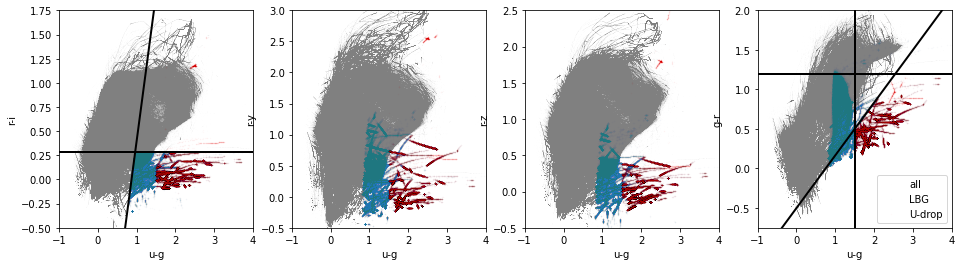

In [16]:
ug = np.linspace(-1, 10, 10)
ri = np.linspace(-1, 10, 10)
gr = np.linspace(-1, 10, 10)

plt.figure(figsize=(16,4))

plt.subplot(141)
plt.scatter(u_min_g, r_min_i, s = 0.1,color='grey', alpha=0.01)
plt.scatter(u_min_g[LBG], r_min_i[LBG], s = 1, alpha=0.01)
plt.scatter(u_min_g[U_drop], r_min_i[U_drop], s = 1, color='red', alpha=0.01)
plt.xlabel('u-g')
plt.ylabel('r-i')
plt.xlim(-1, 4)
plt.ylim(-0.5, 1.75)
plt.plot(ug, 1/0.33 * (ug - 0.87), color='black', lw=2)
plt.axhline(0.28,  color='black', lw=2)

plt.subplot(142)
plt.scatter(u_min_g, r_min_y, s = 0.1, color='grey',alpha=0.01)
plt.scatter(u_min_g[LBG], r_min_y[LBG], s = 1, alpha=0.01)
plt.scatter(u_min_g[U_drop], r_min_y[U_drop], s = 1, color='red', alpha=0.01)
plt.xlabel('u-g')
plt.ylabel('r-y')
plt.xlim(-1, 4)
plt.ylim(-0.5, 3.)

plt.subplot(143)
plt.scatter(u_min_g, r_min_z, s = 0.1, color='grey',alpha=0.01)
plt.scatter(u_min_g[LBG], r_min_z[LBG], s = 1, alpha=0.01)
plt.scatter(u_min_g[U_drop], r_min_z[U_drop], s = 1, color='red', alpha=0.01)
plt.xlabel('u-g')
plt.ylabel('r-z')
plt.xlim(-1, 4)
plt.ylim(-0.5, 2.5)

plt.subplot(144)
plt.scatter(u_min_g, g_min_r, s = 0.1, color='grey',alpha=0.01, label='all')
plt.scatter(u_min_g[LBG], g_min_r[LBG], s = 1, alpha=0.01, label='LBG')
plt.scatter(u_min_g[U_drop], g_min_r[U_drop], s = 1,color='red', alpha=0.01, label ='U-drop')
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim(-1, 4)
plt.ylim(-0.75, 2)
plt.axvline(1.5,  color='black', lw=2)
plt.axhline(1.2,  color='black', lw=2)
plt.axhline(-1.,  color='black', lw=2)
plt.plot(ug, 1/1.5 * (ug - 0.75), color='black', lw=2)
plt.legend()

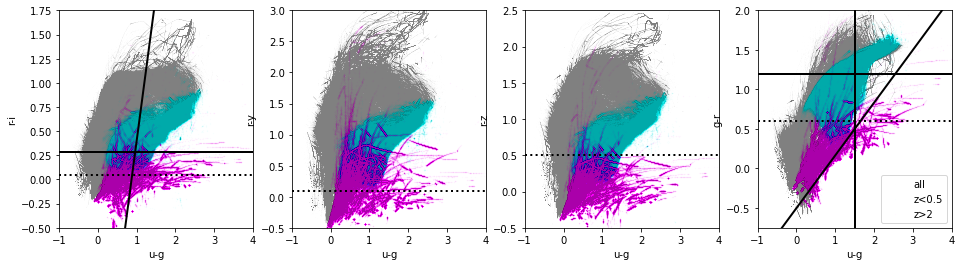

In [17]:
plt.figure(figsize=(16,4))

plt.subplot(141)
plt.scatter(u_min_g, r_min_i, s = 0.1, color='grey', alpha=0.01)
plt.scatter(u_min_g[zlow], r_min_i[zlow], s = 1, color='cyan',alpha=0.01)
plt.scatter(u_min_g[zhigh], r_min_i[zhigh], s = 1,color='magenta', alpha=0.01)
plt.xlabel('u-g')
plt.ylabel('r-i')
plt.xlim(-1, 4)
plt.ylim(-0.5, 1.75)
plt.xlim(-1, 4)
plt.ylim(-0.5, 1.75)
plt.plot(ug, 1/0.33 * (ug - 0.87), color='black', lw=2)
plt.axhline(0.28,  color='black', lw=2)
plt.axhline(0.05,  color='black', lw=2, linestyle='dotted')

plt.subplot(142)
plt.scatter(u_min_g, r_min_y, s = 0.1, color='grey', alpha=0.01)
plt.scatter(u_min_g[zlow], r_min_y[zlow], s = 1, color='cyan', alpha=0.01)
plt.scatter(u_min_g[zhigh], r_min_y[zhigh], s = 1, color='magenta', alpha=0.01)
plt.xlabel('u-g')
plt.ylabel('r-y')
plt.xlim(-1, 4)
plt.ylim(-0.5, 3.)
plt.axhline(0.1,  color='black', lw=2, linestyle='dotted')

plt.subplot(143)
plt.scatter(u_min_g, r_min_z, s = 0.1, color='grey',alpha=0.01)
plt.scatter(u_min_g[zlow], r_min_z[zlow], s = 1, color='cyan', alpha=0.01)
plt.scatter(u_min_g[zhigh], r_min_z[zhigh], s = 1, color='magenta', alpha=0.01)
plt.xlabel('u-g')
plt.ylabel('r-z')
plt.xlim(-1, 4)
plt.ylim(-0.5, 2.5)
plt.axhline(0.5,  color='black', lw=2, linestyle='dotted')

plt.subplot(144)
plt.scatter(u_min_g, g_min_r, s = 0.1, color='grey', alpha=0.01, label='all')
plt.scatter(u_min_g[zlow], g_min_r[zlow], s = 1, color='cyan', alpha=0.01,label='z<0.5')
plt.scatter(u_min_g[zhigh], g_min_r[zhigh], s = 1,color='magenta' ,alpha=0.01, label='z>2')
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.xlim(-1, 4)
plt.ylim(-0.75, 2)
plt.axvline(1.5,  color='black', lw=2)
plt.axhline(1.2,  color='black', lw=2)
plt.axhline(-1.,  color='black', lw=2)
plt.plot(ug, 1/1.5 * (ug - 0.75), color='black', lw=2)
plt.axhline(0.6,  color='black', lw=2, linestyle='dotted')
plt.legend()

# Redshift - magnitude distribution of the color selection

In [18]:
mag_i = gal_cat['mag_i_lsst']

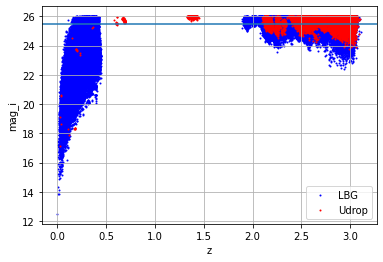

In [19]:
plt.scatter(gal_cat['redshift'][LBG], mag_i[LBG], s=1, color='blue', label='LBG')
plt.scatter(gal_cat['redshift'][U_drop], mag_i[U_drop], s=1, color='red', label='Udrop')

plt.grid()

plt.axhline(25.5)

plt.xlabel('z')
plt.ylabel('mag_i')
plt.legend()

## = > The LBG selection is contaminated with z<0.5 galaxies, the U-drop selection is slightly contaminated with z<1.5 galaxies

# Alternative selection definitions 

## Based on the color-color diagrams we define new selection cut for the LBG and U-drop sample

In [20]:
LBGp = (u_min_g > 0.33 * r_min_i + 0.87) * (r_min_i<0.05)  * (g_min_r<0.6)#lower limit on r-i
LBGpp =  (u_min_g > 0.33 * r_min_i + 0.87) * (r_min_y<0.1)  #limit on r-y instead of r-i

In [21]:
len(gal_cat[LBG]), len(gal_cat[LBGp]), len(gal_cat[LBGpp])

(279844, 110108, 80546)

In [22]:
U_dropp = U_drop * (r_min_z<0.5)

In [23]:
len(gal_cat[U_drop]), len(gal_cat[U_dropp])

(37321, 36848)

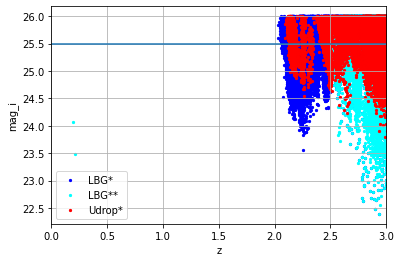

In [24]:
plt.scatter(gal_cat['redshift'][LBGp], mag_i[LBGp], s=5, color='blue', label='LBG*')
plt.scatter(gal_cat['redshift'][LBGpp], mag_i[LBGpp], s=5, color='cyan', label='LBG**')
plt.scatter(gal_cat['redshift'][U_dropp], mag_i[U_dropp], s=5, color='red', label='Udrop*')

plt.grid()

plt.axhline(25.5)
plt.xlim(0,3)

plt.xlabel('z')
plt.ylabel('mag_i')
plt.legend()

## = > The alternatives LBG and Udrop selection are not contaminated by low z galaxies

# Test of color-cut definitions from Medezinski et al. 2018  
- https://arxiv.org/pdf/1706.00427.pdf

In [30]:
CCseq_ll = 2.276 * (r_min_z) - 0.152
CCseq_T = -1/2.276 * (r_min_z) - 0.152/2.276**2

rzseq_ll = - 0.0248 * gal_cat['mag_z_lsst'] + 1.604

red_color1 = g_min_i - CCseq_ll

red_color2 = (g_min_i - CCseq_T) / (1 + 1/2.276**2)

blue_color1 = (r_min_z - rzseq_ll)
blue_color2 = red_color2

#selection to avoid cluster galaxies at z<0.4
sel_red1 = (red_color1 < -0.7) * (red_color2 < 4.) * (r_min_z>0.5)  # * (gal_cat['mag_z_lsst']>21)
sel_blue1 = ((blue_color1 < -0.8) | ((blue_color2 < 0.5) * (g_min_i < 4)))  * (r_min_z<0.5)#   * (gal_cat['mag_z_lsst']>22)

#selection to avoid cluster galaxies at z>0.4
sel_red2 = (red_color1 < -0.8) * (red_color2 < 1.7) * (r_min_z>0.5)  #* (gal_cat['mag_z_lsst']>21)
sel_blue2 = ((blue_color1 < -0.9) | ((blue_color2 < 0.3) * (g_min_i < 4)))  * (r_min_z<0.5)  # * (gal_cat['mag_z_lsst']>22)


### Comparison to cluster member colors

In [31]:
cluster_member = (gal_cat['halo_mass']> 5e13)

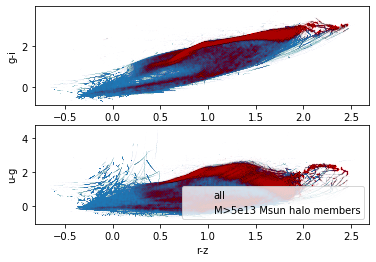

In [32]:
plt.subplot(211)
plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01)
plt.scatter(r_min_z[cluster_member], g_min_i[cluster_member], s = 1, c='red', alpha=0.01)

plt.xlabel('r-z')
plt.ylabel('g-i')

plt.subplot(212)
plt.scatter(r_min_z, u_min_g, s = 0.1, alpha=0.01, label="all")
plt.scatter(r_min_z[cluster_member], u_min_g[cluster_member], s = 1, c='red', alpha=0.01, label='M>5e13 Msun halo members')

plt.xlabel('r-z')
plt.ylabel('u-g')
plt.legend(loc='lower right')

In [33]:
zlow = gal_cat['redshift'] <0.4

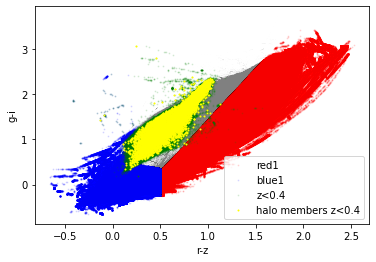

In [34]:
plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01, color='grey')

plt.scatter(r_min_z[sel_red1], g_min_i[sel_red1], s = 1, c='red', alpha=0.1, label='red1')
plt.scatter(r_min_z[sel_blue1], g_min_i[sel_blue1], s = 1, c='blue', alpha=0.1, label='blue1')

plt.scatter(r_min_z[zlow],g_min_i[zlow], s = 1, c='green', alpha=0.1, label='z<0.4')
plt.scatter(r_min_z[zlow*cluster_member],g_min_i[zlow*cluster_member], s = 1, c='yellow', label='halo members z<0.4')

plt.xlabel('r-z')
plt.ylabel('g-i')
plt.legend(loc='lower right')

In [35]:
zmed=(gal_cat['redshift'] <1) * ( gal_cat['redshift'] >0.4)

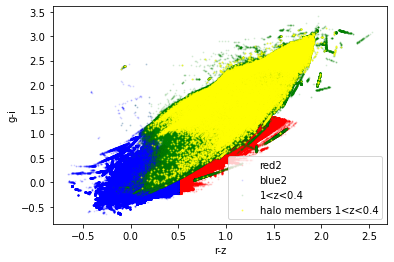

In [36]:
plt.scatter(r_min_z[sel_red2], g_min_i[sel_red2], s = 1, c='red', alpha=0.1, label='red2')
plt.scatter(r_min_z[sel_blue1], g_min_i[sel_blue1], s = 1, c='blue', alpha=0.1, label='blue2')

plt.scatter(r_min_z[zmed],g_min_i[zmed], s = 1, c='green', alpha=0.1,  label='1<z<0.4')
plt.scatter(r_min_z[zmed*cluster_member],g_min_i[zmed*cluster_member], s = 1,  alpha=0.5, c='yellow', label='halo members 1<z<0.4')

plt.xlabel('r-z')
plt.ylabel('g-i')
plt.legend(loc='lower right')

## = > The Medezinski et al. 2018 selections is contaminated with cluster galaxies and galaxies at the tareted redshift range.

# Summarize color selections and compute source number density 

In [25]:
sky_area = extragalactic_cat.sky_area
print( sky_area, 'deg2')

57.07196787435936 deg2


In [26]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)

## - LBG*

`LBGp = (u_min_g > 0.33 * r_min_i + 0.87) *(r_min_i<0.05)  * (g_min_r<0.6)`

In [27]:
LBGp_dens = len(gal_cat[LBGp])/(sky_area*u.deg*u.deg)
print( LBGp_dens, LBGp_dens.value*conv)

1929.283396051743 1 / deg2 0.5359120544588174 1 / arcmin2


## - LBG**

`LBGpp =  (u_min_g > 0.33 * r_min_i + 0.87) * (r_min_y<0.1)`

In [28]:
LBGpp_dens = len(gal_cat[LBGpp])/(sky_area*u.deg*u.deg)
print( LBGpp_dens, LBGpp_dens.value*conv)

1411.305812641985 1 / deg2 0.39202939240055135 1 / arcmin2


## - U-drop*

`Udropp = (u_min_g>1.5) * (g_min_r> -1.) * (g_min_r<1.2) * (u_min_g > (1.5*g_min_r+0.75)) * (r_min_z<0.5)`

In [29]:
Udropp_dens = len(gal_cat[U_dropp])/(sky_area*u.deg*u.deg)
print( Udropp_dens, Udropp_dens.value*conv)

645.6409577661444 1 / deg2 0.17934471049059564 1 / arcmin2


## - Medezinski_2018 color-cuts

In [42]:
MedezinskyR1_dens = len(gal_cat[sel_red1])/(sky_area*u.deg*u.deg)
print(MedezinskyR1_dens, MedezinskyR1_dens.value*conv)

MedezinskyR2_dens = len(gal_cat[sel_red2])/(sky_area*u.deg*u.deg)
print(MedezinskyR2_dens, MedezinskyR2_dens.value*conv)

MedezinskyB1_dens = len(gal_cat[sel_blue1])/(sky_area*u.deg*u.deg)
print(MedezinskyB1_dens, MedezinskyB1_dens.value*conv)

MedezinskyB2_dens = len(gal_cat[sel_blue2])/(sky_area*u.deg*u.deg)
print(MedezinskyB2_dens, MedezinskyB2_dens.value*conv)

117327.75738066602 1 / deg2 32.591043716851665 1 / arcmin2
70900.37632674536 1 / deg2 19.694548979651486 1 / arcmin2
55921.691836980935 1 / deg2 15.533803288050256 1 / arcmin2
47886.74899061693 1 / deg2 13.30187471961581 1 / arcmin2


## Redshift distribution : 

In [1]:
plt.subplot(311)

mag_hist = plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all', color='grey');
plt.hist(gal_cat['redshift'][LBGp],bins=25, range=[0,3], label='LBG*',alpha=0.75, color='purple');
plt.hist(gal_cat['redshift'][LBGpp],bins=25, range=[0,3], label='LBG**',alpha=0.75, color='pink');
plt.hist(gal_cat['redshift'][U_dropp],bins=25, range=[0,3], label='Udrop*',alpha=0.75, color='orange');
plt.yscale('log')
plt.xlabel('z')
plt.legend()

plt.subplot(312)

plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all', color='grey');
plt.hist(gal_cat['redshift'][sel_red1],bins=25, range=[0,3], label='MedezinskyR1',alpha=0.75, color='red');
plt.hist(gal_cat['redshift'][sel_blue1],bins=25, range=[0,3], label='MedezinskyB1',alpha=0.25, color='blue');
plt.yscale('log')
plt.xlabel('z')
plt.legend()

plt.subplot(313)
mag_hist = plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all', color='grey');
plt.hist(gal_cat['redshift'][sel_red2],bins=25, range=[0,3], label='MedezinskyR2',alpha=0.75, color='magenta');
plt.hist(gal_cat['redshift'][sel_blue2],bins=25, range=[0,3], label='MedezinskyB2',alpha=0.25, color='cyan');
plt.yscale('log')
plt.xlabel('z')
plt.legend(loc='upper right')

NameError: name 'plt' is not defined

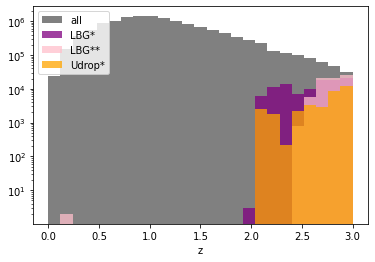

In [30]:
mag_hist = plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all', color='grey');
plt.hist(gal_cat['redshift'][LBGp],bins=25, range=[0,3], label='LBG*',alpha=0.75, color='purple');
plt.hist(gal_cat['redshift'][LBGpp],bins=25, range=[0,3], label='LBG**',alpha=0.75, color='pink');
plt.hist(gal_cat['redshift'][U_dropp],bins=25, range=[0,3], label='Udrop*',alpha=0.75, color='orange');
plt.yscale('log')
plt.xlabel('z')
plt.legend()